In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import KNNImputer

In [2]:
gene_ex = pd.read_csv("SingaporeCRC_data/SG-BULK_salmonTPM.csv", index_col=0, delimiter=",")
gene_ex = gene_ex[gene_ex.sum(axis = 1) > 0]
gene_ex.shape

(58072, 162)

In [3]:
feature_names = gene_ex.T.columns
imputer = KNNImputer(n_neighbors=5, weights="uniform")
gene_ex = imputer.fit_transform(gene_ex)
gene_ex = gene_ex.T
gene_ex = pd.DataFrame(gene_ex, columns = feature_names)
gene_ex.shape

(162, 58072)

In [4]:
metadata = pd.read_csv('SingaporeCRC_data/SG-BULK_patient_clinical_information.csv', index_col=0,delimiter=",")
metadata = metadata.dropna()
print(metadata)

             TMB KRAS BRAF NRAS TP53  APC PIK3CA PIK3R1 SMAD4 ERBB4  ...  \
patient_id                                                           ...   
106         1028   wt   wt   wt   wt   wt     wt     wt    wt    wt  ...   
153           80  mut   wt   wt  mut  mut    mut     wt    wt    wt  ...   
269           10   wt   wt   wt   wt   wt     wt     wt    wt    wt  ...   
326         1512  mut   wt   wt   wt   wt     wt     wt    wt   mut  ...   
420         1976  mut   wt   wt  mut  mut     wt     wt    wt    wt  ...   
...          ...  ...  ...  ...  ...  ...    ...    ...   ...   ...  ...   
1658          82  mut   wt   wt  mut  mut     wt     wt    wt    wt  ...   
1662          74  mut   wt   wt  mut   wt     wt     wt    wt    wt  ...   
1664          46  mut   wt   wt  mut   wt     wt     wt    wt    wt  ...   
1665          93  mut   wt   wt  mut  mut     wt     wt    wt    wt  ...   
1672        1198   wt  mut   wt   wt   wt     wt     wt    wt    wt  ...   

           

In [5]:
print(metadata.columns)

Index(['TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA', 'PIK3R1',
       'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2', 'Vital.status',
       'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'],
      dtype='object')


In [6]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

gene_ex_reset = gene_ex.reset_index()
metadata_reset = metadata.reset_index()

SG_CRC_gene = pd.merge(gene_ex_reset, metadata_reset, left_index=True, right_index=True)
SG_CRC_gene.columns = [regex.sub("_",col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in SG_CRC_gene.columns.values]
SG_CRC_gene
#SG_CRC.to_csv('merged_CRC', index = False)


,index,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
0,0,21.899490,0.201798,24.813475,2.385601,2.423479,1.719561,4.938426,17.340649,17.525062,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
1,1,23.051914,0.336181,32.488898,3.491298,4.838602,1.709233,5.097042,23.091196,25.009775,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,IIIB,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
2,2,17.759606,0.321224,73.592613,3.189865,4.491900,0.835416,2.342624,26.887325,30.539995,...,54.0,Rectum,Left,2,T1N1c(0/11)M0,IIIB,iCMS3,CMS4,iCMS3_MSS,iCMS3_fibrotic
3,3,19.887544,0.495977,17.660135,3.426733,2.546456,0.686355,1.877872,16.863628,19.586386,...,55.0,Rectosigmoid junction,Left,2,Unknown,II,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,4,10.718835,0.092844,22.659393,2.741735,3.737818,0.692069,1.440818,10.085834,14.951673,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,108,25.446559,3.078775,31.025019,2.308085,3.023469,0.719722,0.604158,15.529829,14.441967,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
109,109,11.872265,0.097446,18.464622,3.007761,3.117944,1.738229,1.985157,14.286709,19.893672,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
110,110,20.488634,0.242216,28.991172,4.016559,4.961455,1.223993,2.134570,17.637516,25.117022,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
111,111,17.043407,0.467192,22.989287,4.396584,5.646108,2.844927,2.356601,17.882812,23.797957,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [8]:
print(SG_CRC_gene.columns)
class_counts = SG_CRC_gene['MSI.Status'].value_counts()
print(class_counts)

Index(['index', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'Age.at.Diagnosis', 'Site.of.Primary.Colorectal.tumour', 'Side',
       'Grade', 'TNM', 'Stage', 'iCMS', 'CMS', 'group3', 'group5'],
      dtype='object', length=58102)
MSI.Status
MSS    89
MSI    24
Name: count, dtype: int64


In [9]:
# Prepare features and target variable
X = SG_CRC_gene.drop(['index','TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA', 'PIK3R1',
       'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2', 'Vital.status',
       'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_CRC_gene['MSI.Status']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['MSI' 'MSS']
Unique values of y: [0 1]
Shape of y: (113, 58073)
Shape of y: (113,)


In [10]:
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)

(178, 58073)
(178,)


Best Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.8633333333333335
Test Set Accuracy: 0.9259259259259259


<Figure size 800x600 with 0 Axes>

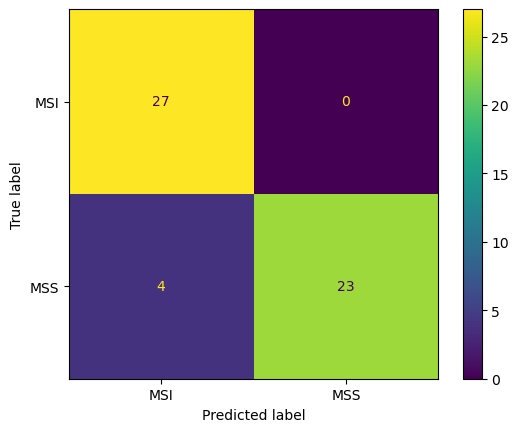

In [16]:
from sklearn.svm import SVC

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for SVM
params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
}

# Initialize SVM classifier
svm_model = SVC()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

# Get the predicted labels
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MSI', 'MSS'])
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
cm_display.plot()  # Plot confusion matrix
plt.show()

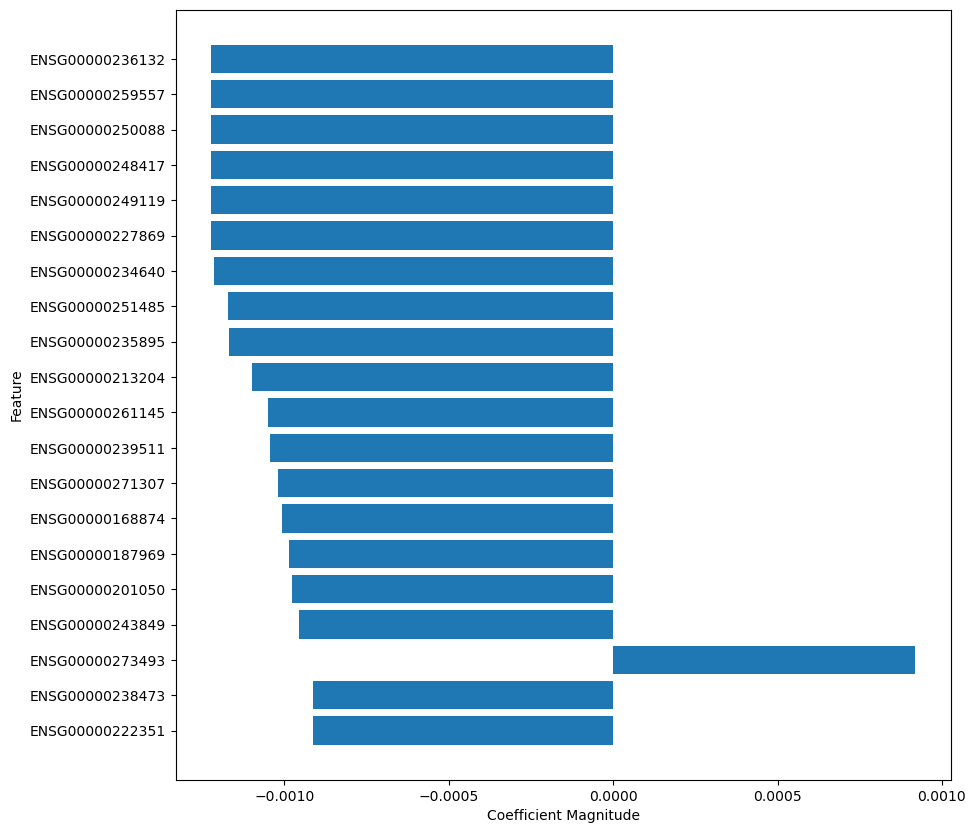

In [17]:
# Fit an SVM model with the best parameters
best_svm_model = SVC(**best_params)
best_svm_model.fit(X_train, y_train)

# Get the coefficients if using a linear kernel
if best_params['kernel'] == 'linear':
    coef = best_svm_model.coef_.ravel()
    feature_names = np.array(SG_CRC_gene.columns)  # Assuming you have feature names
    # Get the indices of top 20 features by absolute coefficient values
    top_20_indices = np.argsort(np.abs(coef))[::-1][:20]
    top_20_features = feature_names[top_20_indices]
    top_20_coef = coef[top_20_indices]

    # Plot the top 20 features
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(top_20_coef)), top_20_coef, align='center')
    plt.yticks(range(len(top_20_coef)), top_20_features)
    plt.xlabel('Coefficient Magnitude')
    plt.ylabel('Feature')
    #plt.title('Top 20 Important Features (SVM - Linear Kernel)')
    plt.gca().invert_yaxis()  # Invert y-axis to have highest coefficient at the top
    plt.show()
else:
    print("Feature importances are not available for non-linear SVM kernels.")